# Alzheimer's Disease classification from anatomical MRI

### This notebook explores the use of transfer learning with ResNet50 to classify Alzheimer's disease from anatomical MRI images.

Briefly, the pipeline involves the following steps and technical features:

- Data formating and quality check
- Transfer learning using ResNet50
- Hyperparameter tuning
- Final model application

### Import analysis and plotting libraries

In [0]:
# extract aws credentials from hidden table 
aws_keys_df = spark.read.format("csv").option("header", "true").option("sep", ",").load("/FileStore/tables/brad_databricks_personal_accessKeys_new.csv")

ACCESS_KEY = aws_keys_df.collect()[0][0]
SECRET_KEY = aws_keys_df.collect()[0][1]

# specify bucket and mount point
AWS_S3_BUCKET = "databricks-workspace-stack-brad-personal-bucket/AD_MRI_classification/"
MOUNT_NAME = "/mnt/AD_classification"
SOURCE_URL = f"s3a://{AWS_S3_BUCKET}"
EXTRA_CONFIGS = { "fs.s3a.access.key": ACCESS_KEY, "fs.s3a.secret.key": SECRET_KEY}

# mount bucket
# dbutils.fs.unmount(MOUNT_NAME)
# dbutils.fs.mount(SOURCE_URL, MOUNT_NAME, extra_configs = EXTRA_CONFIGS)

In [0]:
# "standard"
import numpy as np
import pandas as pd

# machine learning and statistics
import pyspark
from pyspark.sql import SparkSession
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.utils import plot_model
from keras import regularizers
from keras import applications, layers, models, applications, callbacks, optimizers
import keras_tuner as kt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scipy.stats import false_discovery_control
from imblearn.over_sampling import SMOTE

# Parallel computing
import dask
from dask.distributed import Client, progress

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# misc
import cv2
import magic
from IPython.display import clear_output
clear_output(wait=False)

### Load and format training data

In [0]:
Lab = ['Mild', 'Moderate', 'None', 'Very Mild']

train = pd.read_parquet("/dbfs/mnt/AD_classification/train-00000-of-00001-c08a401c53fe5312.parquet")
train.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2


#### Convert data to readable format

In [0]:
def dict_to_image(image_dict):
    if isinstance(image_dict, dict) and 'bytes' in image_dict:
        byte_string = image_dict['bytes']
        nparr = np.frombuffer(byte_string, np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
        return img
    else:
        raise TypeError(f"Expected dictionary with 'bytes' key, got {type(image_dict)}")

train['img_arr'] = train['image'].apply(dict_to_image)
train.drop("image", axis=1, inplace=True)
train.head()

,label,img_arr
0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


### Load and format test data

In [0]:
test = pd.read_parquet("/dbfs/mnt/AD_classification/test-00000-of-00001-44110b9df98c5585.parquet")

test['img_arr'] = test['image'].apply(dict_to_image)
test.drop("image", axis=1, inplace=True)
test.head()

,label,img_arr
0,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


## Explore structure and visualization of the data

### Distribution of the datasets (are all classes represented equally?)

Text(0, 0.5, '# of images')

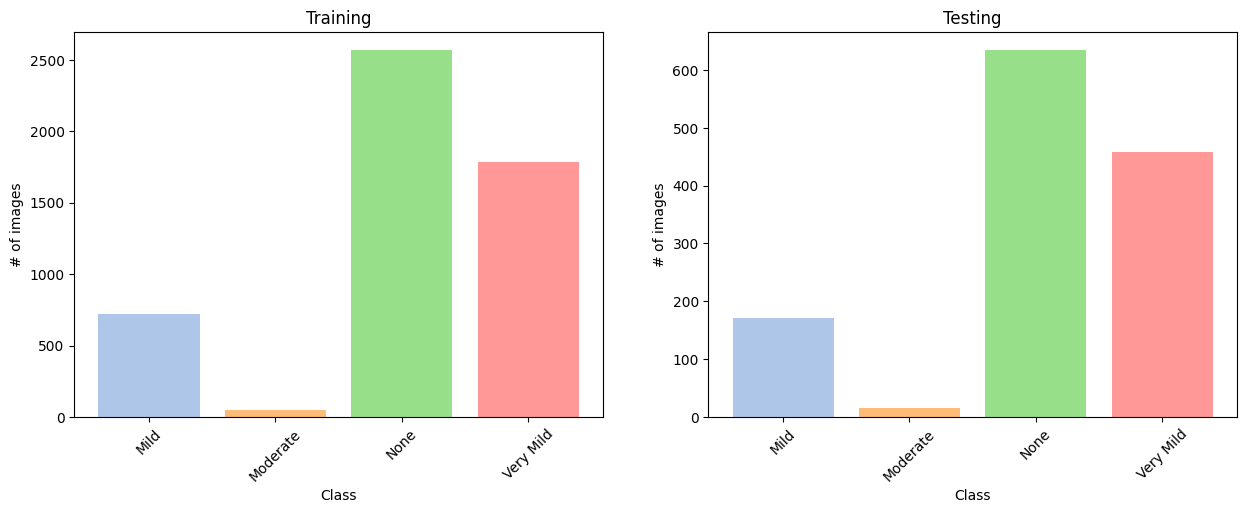

In [0]:
colors = ['#aec7e8', '#ffbb78', '#98df8a', '#ff9896']

f, ax = plt.subplots(1, 2, figsize=(15, 5))
unique, counts = np.unique(np.asarray(train.iloc[:].label), return_counts=True)
ax[0].bar(unique, counts, color=colors)
ax[0].set_xticks(unique)
ax[0].set_xticklabels(Lab, rotation=45)
ax[0].set_title('Training')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('# of images')

unique, counts = np.unique(np.asarray(test.iloc[:].label), return_counts=True)
ax[1].bar(unique, counts, color=colors)
ax[1].set_xticks(unique)
ax[1].set_xticklabels(Lab, rotation=45)
ax[1].set_title('Testing')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('# of images')

# An obvious imbalance across classes, but each class seems to be balanced across training/testing sets

## Visually inspect data

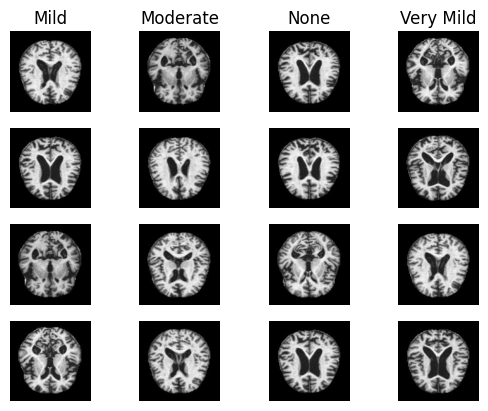

In [0]:
train_lab_idx = np.asarray(train.iloc[:].label)

f, ax = plt.subplots(4,4)
for lab in range(4):
    for ex in range(4):
    
        class_lab = np.argwhere(train_lab_idx == 1)
        current_idx = np.random.randint(len(class_lab)-1,size = 1)
        current_idx = np.asarray(current_idx)
        
        ax[ex, lab].axis('off')
        ax[ex, lab].imshow(train.iloc[class_lab[current_idx[0]][0]].img_arr, cmap = "gray")
        if ex == 0: ax[ex, lab].set_title(Lab[lab])

## Load and adapt ResNet50

Format images (stored in local memory)

In [0]:
# training data
train_data = np.empty((len(train), 128, 128))
for i in range(len(train)):
   train_data[i, :, :] = train.iloc[i].img_arr

# test data
test_data = np.empty((len(test), 128, 128))
for i in range(len(test)):
   test_data[i, :, :] = test.iloc[i].img_arr

# format in 3D shape that keras likes
train_data = np.expand_dims(train_data, axis = 3)
test_data = np.expand_dims(test_data, axis = 3)
train_data.shape

(5120, 128, 128, 1)

Data augmentation

In [0]:
# Resize and rescale functions
IMG_SIZE = 128
resize_and_rescale = keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000, reshuffle_each_iteration=True)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

clear_output(wait=False)

### Augment training dataset only

Augment multiple times to generate larger training set

In [0]:
train_ds = tf.data.Dataset.from_tensor_slices((train_data, train_lab_idx))
train_ds_for_aug = train_ds

for i in range(1):
    train_aug = prepare(train_ds_for_aug, shuffle = True, augment = True)
    train_aug = train_aug.unbatch()
    train_aug = train_aug.map(lambda x, y: (tf.cast(x, tf.float64), y))
    train_ds = train_ds.concatenate(train_aug)

del train_aug, train_ds_for_aug
images = np.asarray(list(train_ds.map(lambda x, y: x)))
labels = np.asarray(list(train_ds.map(lambda x, y: y)))
clear_output(wait=False)
images.shape

(10240, 128, 128, 1)

### Load pre-trained ResNet50 model and adjust for current dataset

In [0]:
test_lab_idx = np.asarray(test.iloc[:].label)

# Modify the ResNet50 model to accept grayscale images
res_model = applications.ResNet50(include_top=False, weights=None, input_shape=(128, 128, 3))

# Freeze all layers except the last block
for layer in res_model.layers[:-10]:
    layer.trainable = False

# Print layers to verify
for i, layer in enumerate(res_model.layers):
    print(f"Layer {i}: {layer.name}, Trainable: {layer.trainable}")

# Add a Conv2D layer to convert grayscale images to 3 channels
input_layer = layers.Input(shape=(128, 128, 1))
x = layers.Conv2D(3, (3, 3), padding='same')(input_layer)
x = res_model(x)
x = layers.Flatten()(x)
x = layers.Dense(4, activation='softmax')(x)  # Add Dense layer with number of classes

Layer 0: input_layer_2, Trainable: False
Layer 1: conv1_pad, Trainable: False
Layer 2: conv1_conv, Trainable: False
Layer 3: conv1_bn, Trainable: False
Layer 4: conv1_relu, Trainable: False
Layer 5: pool1_pad, Trainable: False
Layer 6: pool1_pool, Trainable: False
Layer 7: conv2_block1_1_conv, Trainable: False
Layer 8: conv2_block1_1_bn, Trainable: False
Layer 9: conv2_block1_1_relu, Trainable: False
Layer 10: conv2_block1_2_conv, Trainable: False
Layer 11: conv2_block1_2_bn, Trainable: False
Layer 12: conv2_block1_2_relu, Trainable: False
Layer 13: conv2_block1_0_conv, Trainable: False
Layer 14: conv2_block1_3_conv, Trainable: False
Layer 15: conv2_block1_0_bn, Trainable: False
Layer 16: conv2_block1_3_bn, Trainable: False
Layer 17: conv2_block1_add, Trainable: False
Layer 18: conv2_block1_out, Trainable: False
Layer 19: conv2_block2_1_conv, Trainable: False
Layer 20: conv2_block2_1_bn, Trainable: False
Layer 21: conv2_block2_1_relu, Trainable: False
Layer 22: conv2_block2_2_conv, Tra

In [0]:
model = models.Model(inputs=input_layer, outputs=x)
std_learning_rate = 1e-4
model.compile(optimizer = keras.optimizers.Adam(learning_rate = std_learning_rate),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy']
)

# Convert labels to categorical
train_labels_cat = to_categorical(train_lab_idx.astype('int8'), num_classes=4)
test_labels_cat = to_categorical(test_lab_idx.astype('int8'), num_classes=4)

# Train the model
history = model.fit(
    train_data, train_labels_cat, epochs=10, 
    validation_data=(test_data, test_labels_cat)
)

Epoch 1/10
136/160 ━━━━━━━━━━━━━━━━━[0

*** WARNING: max output size exceeded, skipping output. ***

160/160 ━━━━━━━━━━━━━━━━━━━━ 707s 4s/step - accuracy: 0.7829 - loss: 0.5566 - val_accuracy: 0.5953 - val_loss: 2.0901


View results

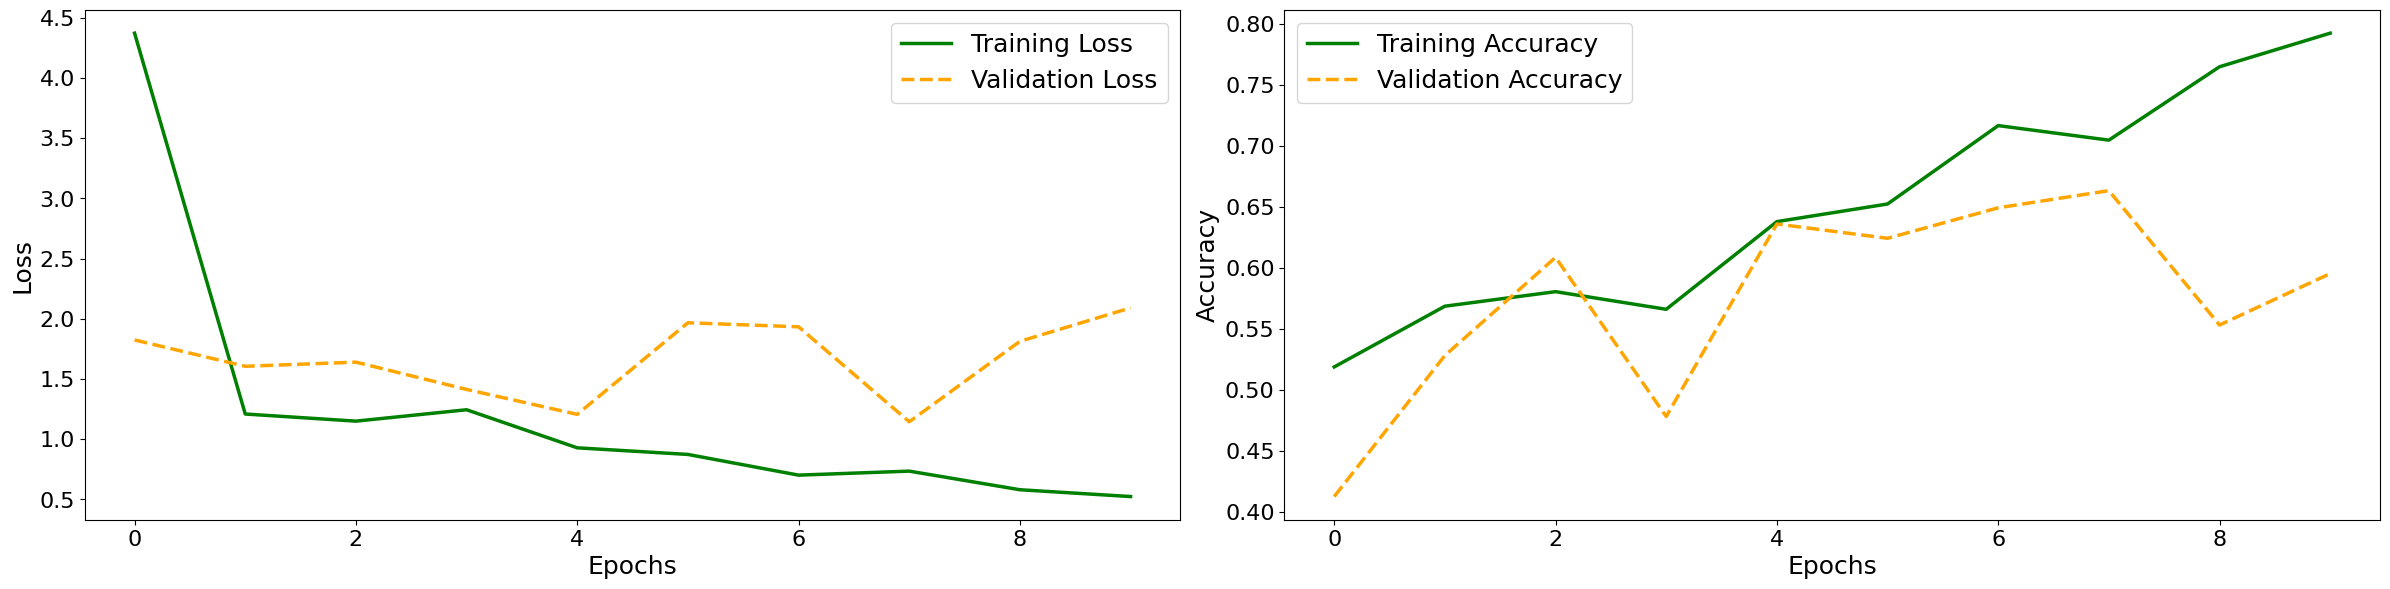

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6))

# Plot training and validation loss
ax1.set_xlabel('Epochs', fontsize=18)
ax1.set_ylabel('Loss', fontsize=18)
ax1.plot(history.history['loss'], color='green', label='Training Loss', linewidth=2.5)
ax1.plot(history.history['val_loss'], color='orange', linestyle='--', label='Validation Loss', linewidth=2.5)
ax1.legend(loc='upper right', fontsize=18)
ax1.tick_params(axis='both', which='major', labelsize=16)

# Plot training and validation accuracy
ax2.set_xlabel('Epochs', fontsize=18)
ax2.set_ylabel('Accuracy', fontsize=18)
ax2.plot(history.history['accuracy'], color='green', label='Training Accuracy', linewidth=2.5)
ax2.plot(history.history['val_accuracy'], color='orange', linestyle='--', label='Validation Accuracy', linewidth=2.5)
ax2.legend(loc='upper left', fontsize=18)
ax2.tick_params(axis='both', which='major', labelsize=16)

fig.tight_layout()
plt.show()

Fine tune the ResNet50

In [0]:
res_model.trainable = True

# How many layers are in the base model
print("Number of layers in ResNet50: ", len(res_model.layers))

# Fine-tune from this layer onwards and freeze all layers before
fine_tune_at = 100
for layer in res_model.layers[:fine_tune_at]:
  layer.trainable = False